# **2. Model + Dropout**

Our next goal is optimizing the base model so that we can reach higher accuracies and avoid overfitting as much as possible. We will first start by increasing the complexity of the base model (i.e.: adding more layers), as well as incorporating regularization techniques to prevent us from overfitting to the training set. 

In this notebook we will explore the power of dropout for helping us reduce overfitting to the data. We will start by building a similar architecture to the one used by the base model, reusing the weights from the previously trained model. We will only be training the fully-connected layers in this case, freezing the convolutional part of the network. This will allow for a faster training process (similar to the approach taken in transfer learning), where our only goal is using dropout to avoid overfitting to the data. 

We will start by defining a relatively small dropout rate (0.05). Since we will be increasing the number of samples by using data augmentation later on, using a higher penalty will probably hinder the training process and ultimately causing the model to meet early stopping criteria before converging.

First of all, let's load the required libraries in order to run the code:

In [1]:
# Base libraries
import os

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Tensorflow
import tensorflow.keras as keras
from tensorflow.keras import optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Own modules
from src.utils import drop_checkpoints, dataset_stats, plot_metric_curves

Now let's see how our data is structured:

In [2]:
# Root folder
base_dir = "./data"

In [3]:
# Train folder
train_dir = os.path.join(base_dir, "train")

# Validation folder
validation_dir = os.path.join(base_dir, "validation")

# Test folder
test_dir = os.path.join(base_dir, "test")

In [4]:
drop_checkpoints(base_dir)

Let's also see how many images there are for each class in the training, validation and test set.

In [5]:
dataset_stats(train_dir, validation_dir, test_dir)

Number of classes: 4
Existing classes: ['Baroque', 'Realism', 'Renaissance', 'Romanticism']

----------------------------------------
Number of images per class and dataset:
----------------------------------------
             Train  Validation  Test
Style                               
Baroque       4000         500   500
Realism       4000         500   500
Renaissance   4000         500   500
Romanticism   4000         500   500


We'll also create the directory, if not created yet, where the models will be saved:

In [6]:
# Create directory where to save the models created
models_dir = "./models"
os.makedirs(models_dir, exist_ok=True)

### 1.1. Model structure

Let's first create the model structure:

Firstly, let's define the values of some hyperparameters:

In [7]:
# Define some hyperparameters' values

# Input shape
input_shape = (256, 256,  3)

# Batch_size and steps per epoch
training_size = sum([len(file) for path, folder, file in os.walk(train_dir)])
batch_size = 128
steps_per_epoch = training_size // batch_size
print(f"Steps per epoch: {steps_per_epoch}")

Steps per epoch: 125


In [8]:
model = models.Sequential()
# 1st Convolution Layer
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=input_shape
                        )
)
# 1st Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))
# 2nd Convolution Layer
model.add(layers.Conv2D(64, 
                        (3, 3), 
                        activation='relu'
                       )
         )
# 2nd Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))
# 3rd Convolution Layer
model.add(layers.Conv2D(128, 
                        (3, 3), 
                        activation='relu'
                        )
)
# 3rd Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))
# 4th Convolution Layer
model.add(layers.Conv2D(128, 
                        (3, 3), 
                        activation='relu'
                        )
)
# 4th Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(4, activation='softmax'))

Once the structure of the base model has been defined, let's see exactly how many parameters it has in order to have a better idea of how flexible this model is:

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

We'll use Adam as our optimizer since it is the most popular optimizer right now, as well as versatile (i.e., it can be used in multiple contexts).

In [10]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=1e-4),
    metrics=['acc']
)

### 1.2. Data preprocessing

In [11]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        # All images will be resized to the dimensions specified
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
        )

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        # All images will be resized to the dimensions specified
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
        )

Found 16000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.


Now let's take a look at the output of one of these generators (for instance, the training one):

In [12]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (128, 256, 256, 3)
labels batch shape: (128, 4)


*We can appreciate that...*

### 1.3. Training

We can now train this improved version of our model and see if it improves performance upon the first version. We will still implement EarlyStopping to make sure we avoid *overfitting* as much as possible.

We use [Early Stopping](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/) to limit *overfitting*, as well `ModelCheckpoint` to save the best model obtained during training. We will using validation loss as metric function for early stopping, setting a patience of 5 (i.e.: we will stop after there is no significant change in validation loss for 5 epochs of training). Since we are dealing with a relatively small dataset, we can set a high enough number of epochs (in this case we chose 100), as we can be fairly sure that training will be stopped before reaching the limit.

In [13]:
# Model name and path
model_path = os.path.join("models", "dropout_model.h5")

In [14]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(model_path, monitor='val_loss', 
                     mode='min', verbose=1, save_best_only=True)

In [15]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=10,
    callbacks = [es, mc]
)

Epoch 1/30
  1/125 [..............................] - ETA: 14:53 - loss: 1.3876 - acc: 0.2422

c:\Users\carlo\anaconda3\envs\venv_art\lib\site-packages\PIL\TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


125/125 [==============================] - ETA: 0s - loss: 1.2702 - acc: 0.4207
Epoch 1: val_loss improved from inf to 1.12679, saving model to models\dropout_model.h5
125/125 [==============================] - 644s 5s/step - loss: 1.2702 - acc: 0.4207 - val_loss: 1.1268 - val_acc: 0.5578
Epoch 2/30
125/125 [==============================] - ETA: 0s - loss: 1.1268 - acc: 0.5178
Epoch 2: val_loss improved from 1.12679 to 1.12130, saving model to models\dropout_model.h5
125/125 [==============================] - 549s 4s/step - loss: 1.1268 - acc: 0.5178 - val_loss: 1.1213 - val_acc: 0.5375
Epoch 3/30
125/125 [==============================] - ETA: 0s - loss: 1.0612 - acc: 0.5519
Epoch 3: val_loss improved from 1.12130 to 1.05073, saving model to models\dropout_model.h5
125/125 [==============================] - 540s 4s/step - loss: 1.0612 - acc: 0.5519 - val_loss: 1.0507 - val_acc: 0.5820
Epoch 4/30
125/125 [==============================] - ETA: 0s - loss: 1.0289 - acc: 0.5646
Epoch 4: 

Now let's load the best model found:

In [16]:
# load the saved model
saved_model = load_model(model_path)

### 1.4. Validation

Let's plot how the loss and the accuracy from both training and validations sets have evolved during the training process. 

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

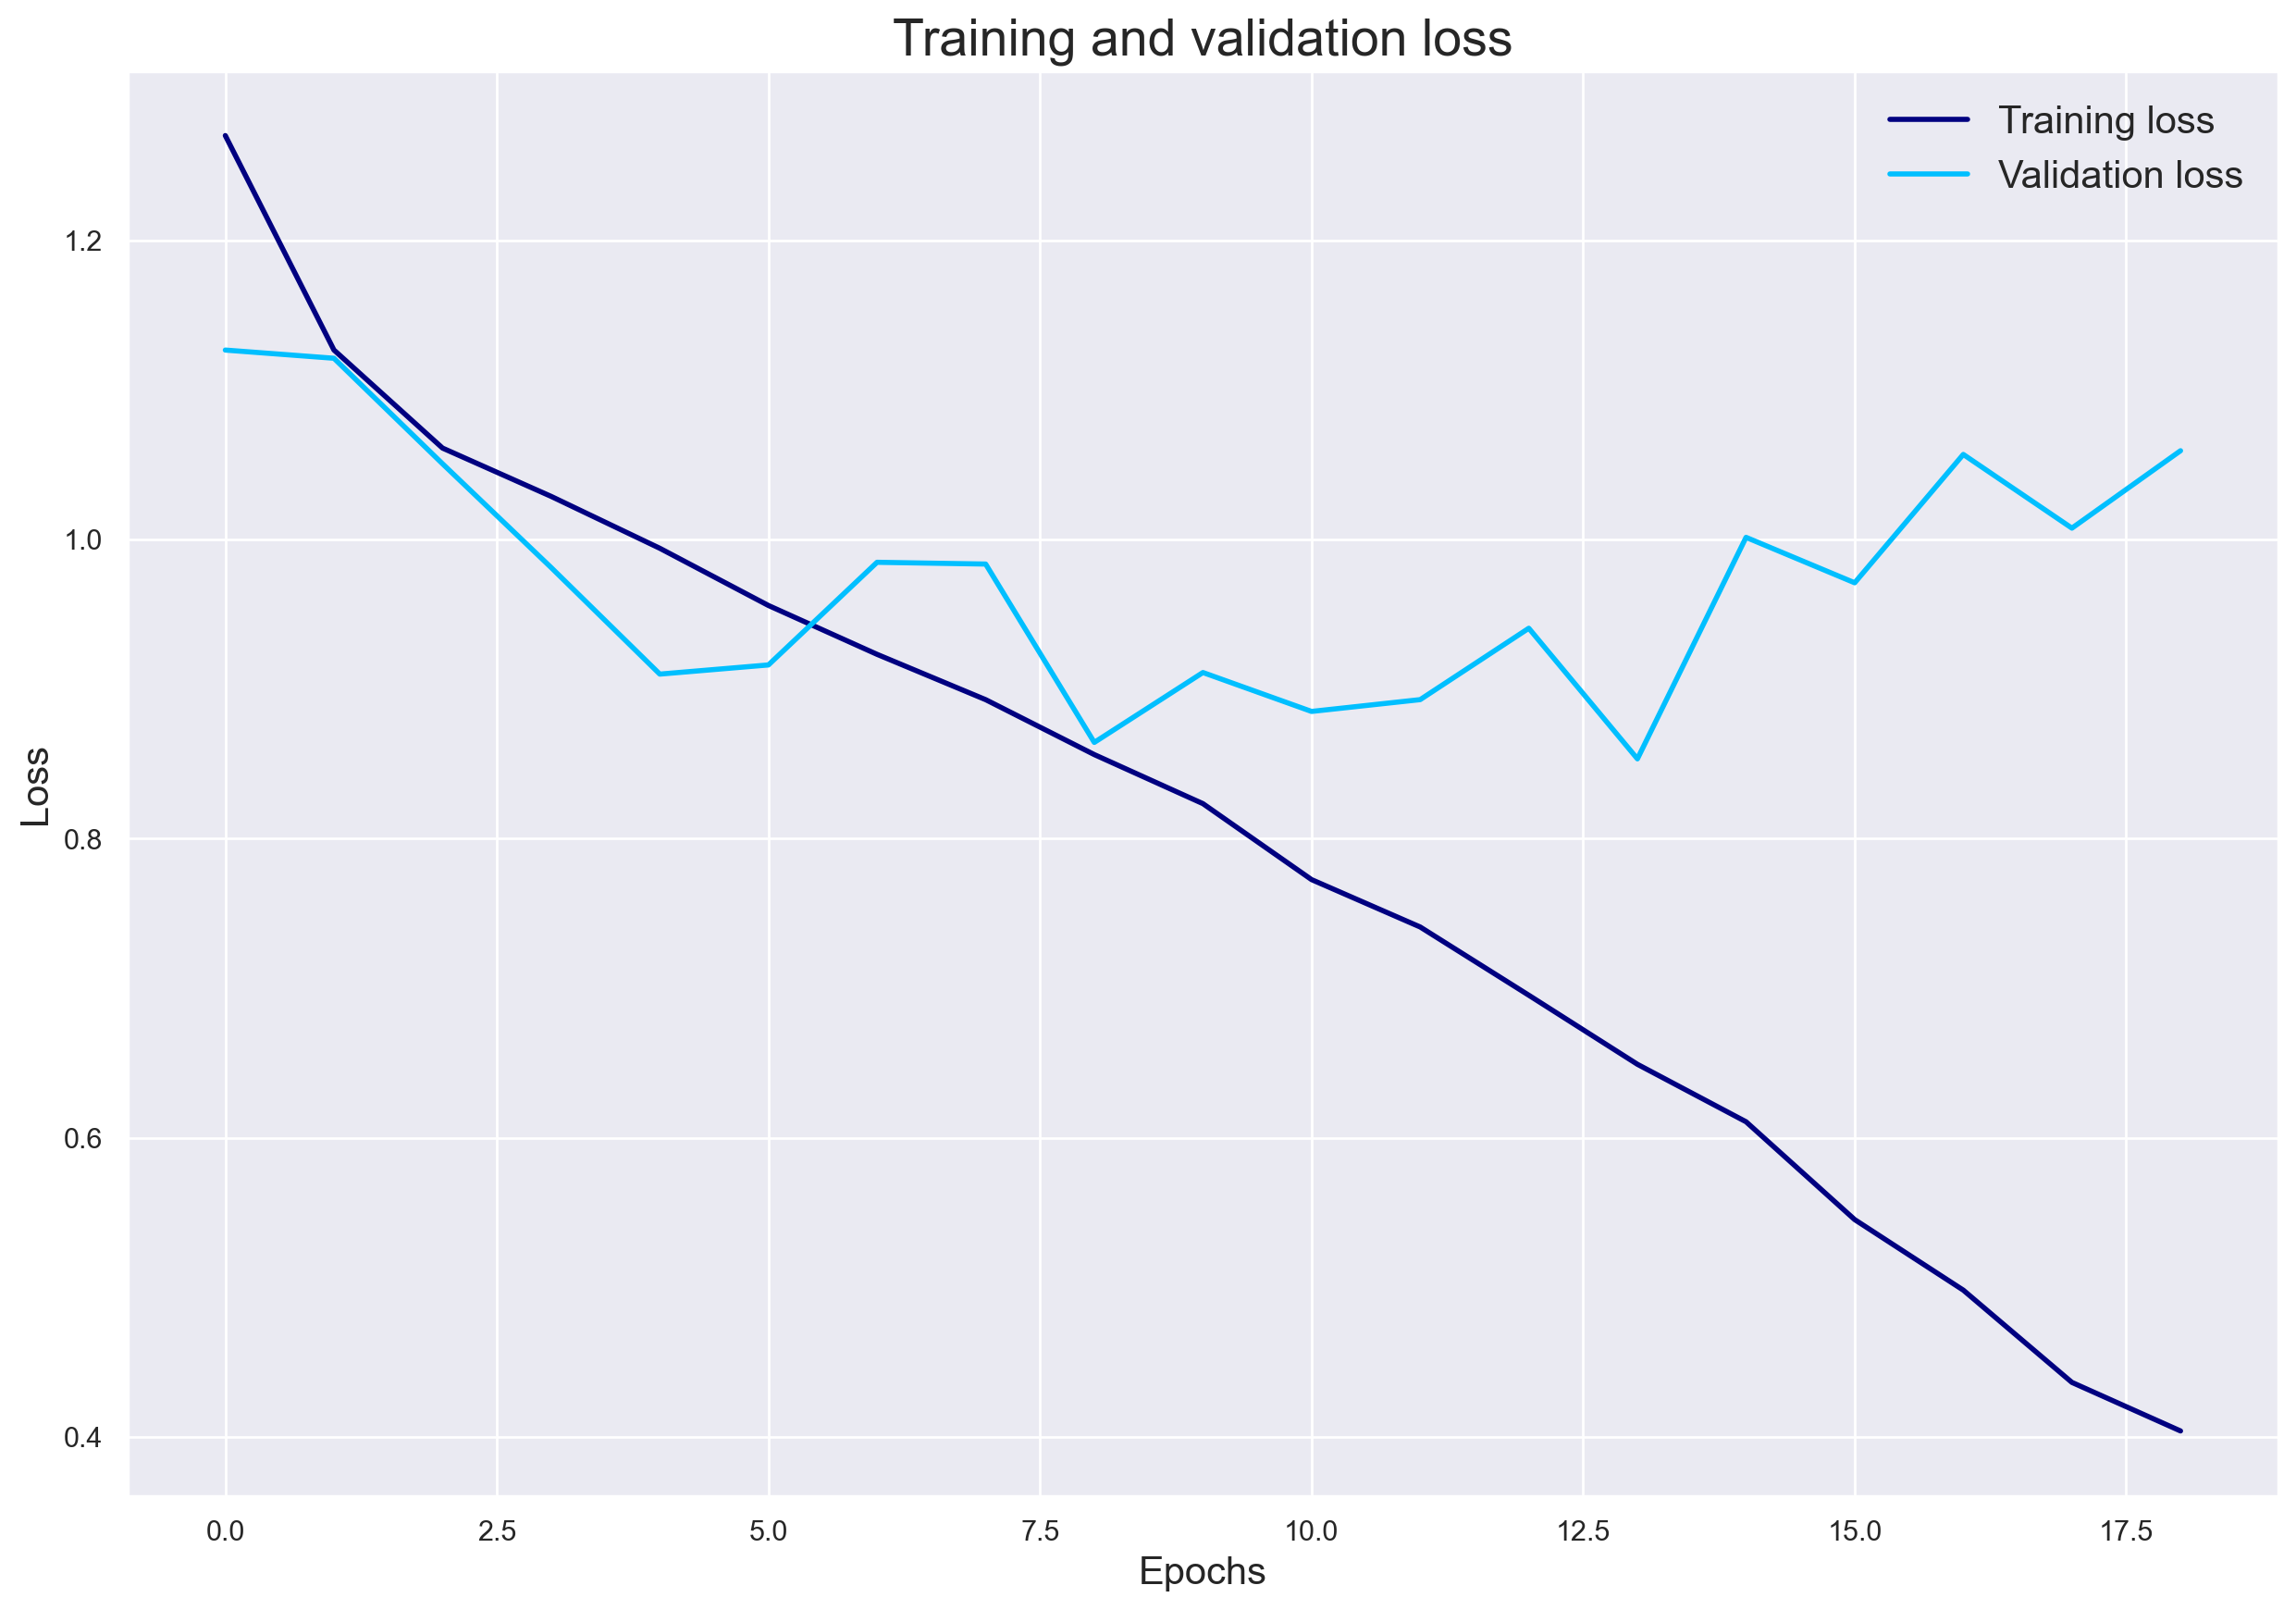

In [18]:
# Plot loss curves
plot_metric_curves(epochs, loss, val_loss, "navy", "deepskyblue", "Loss")

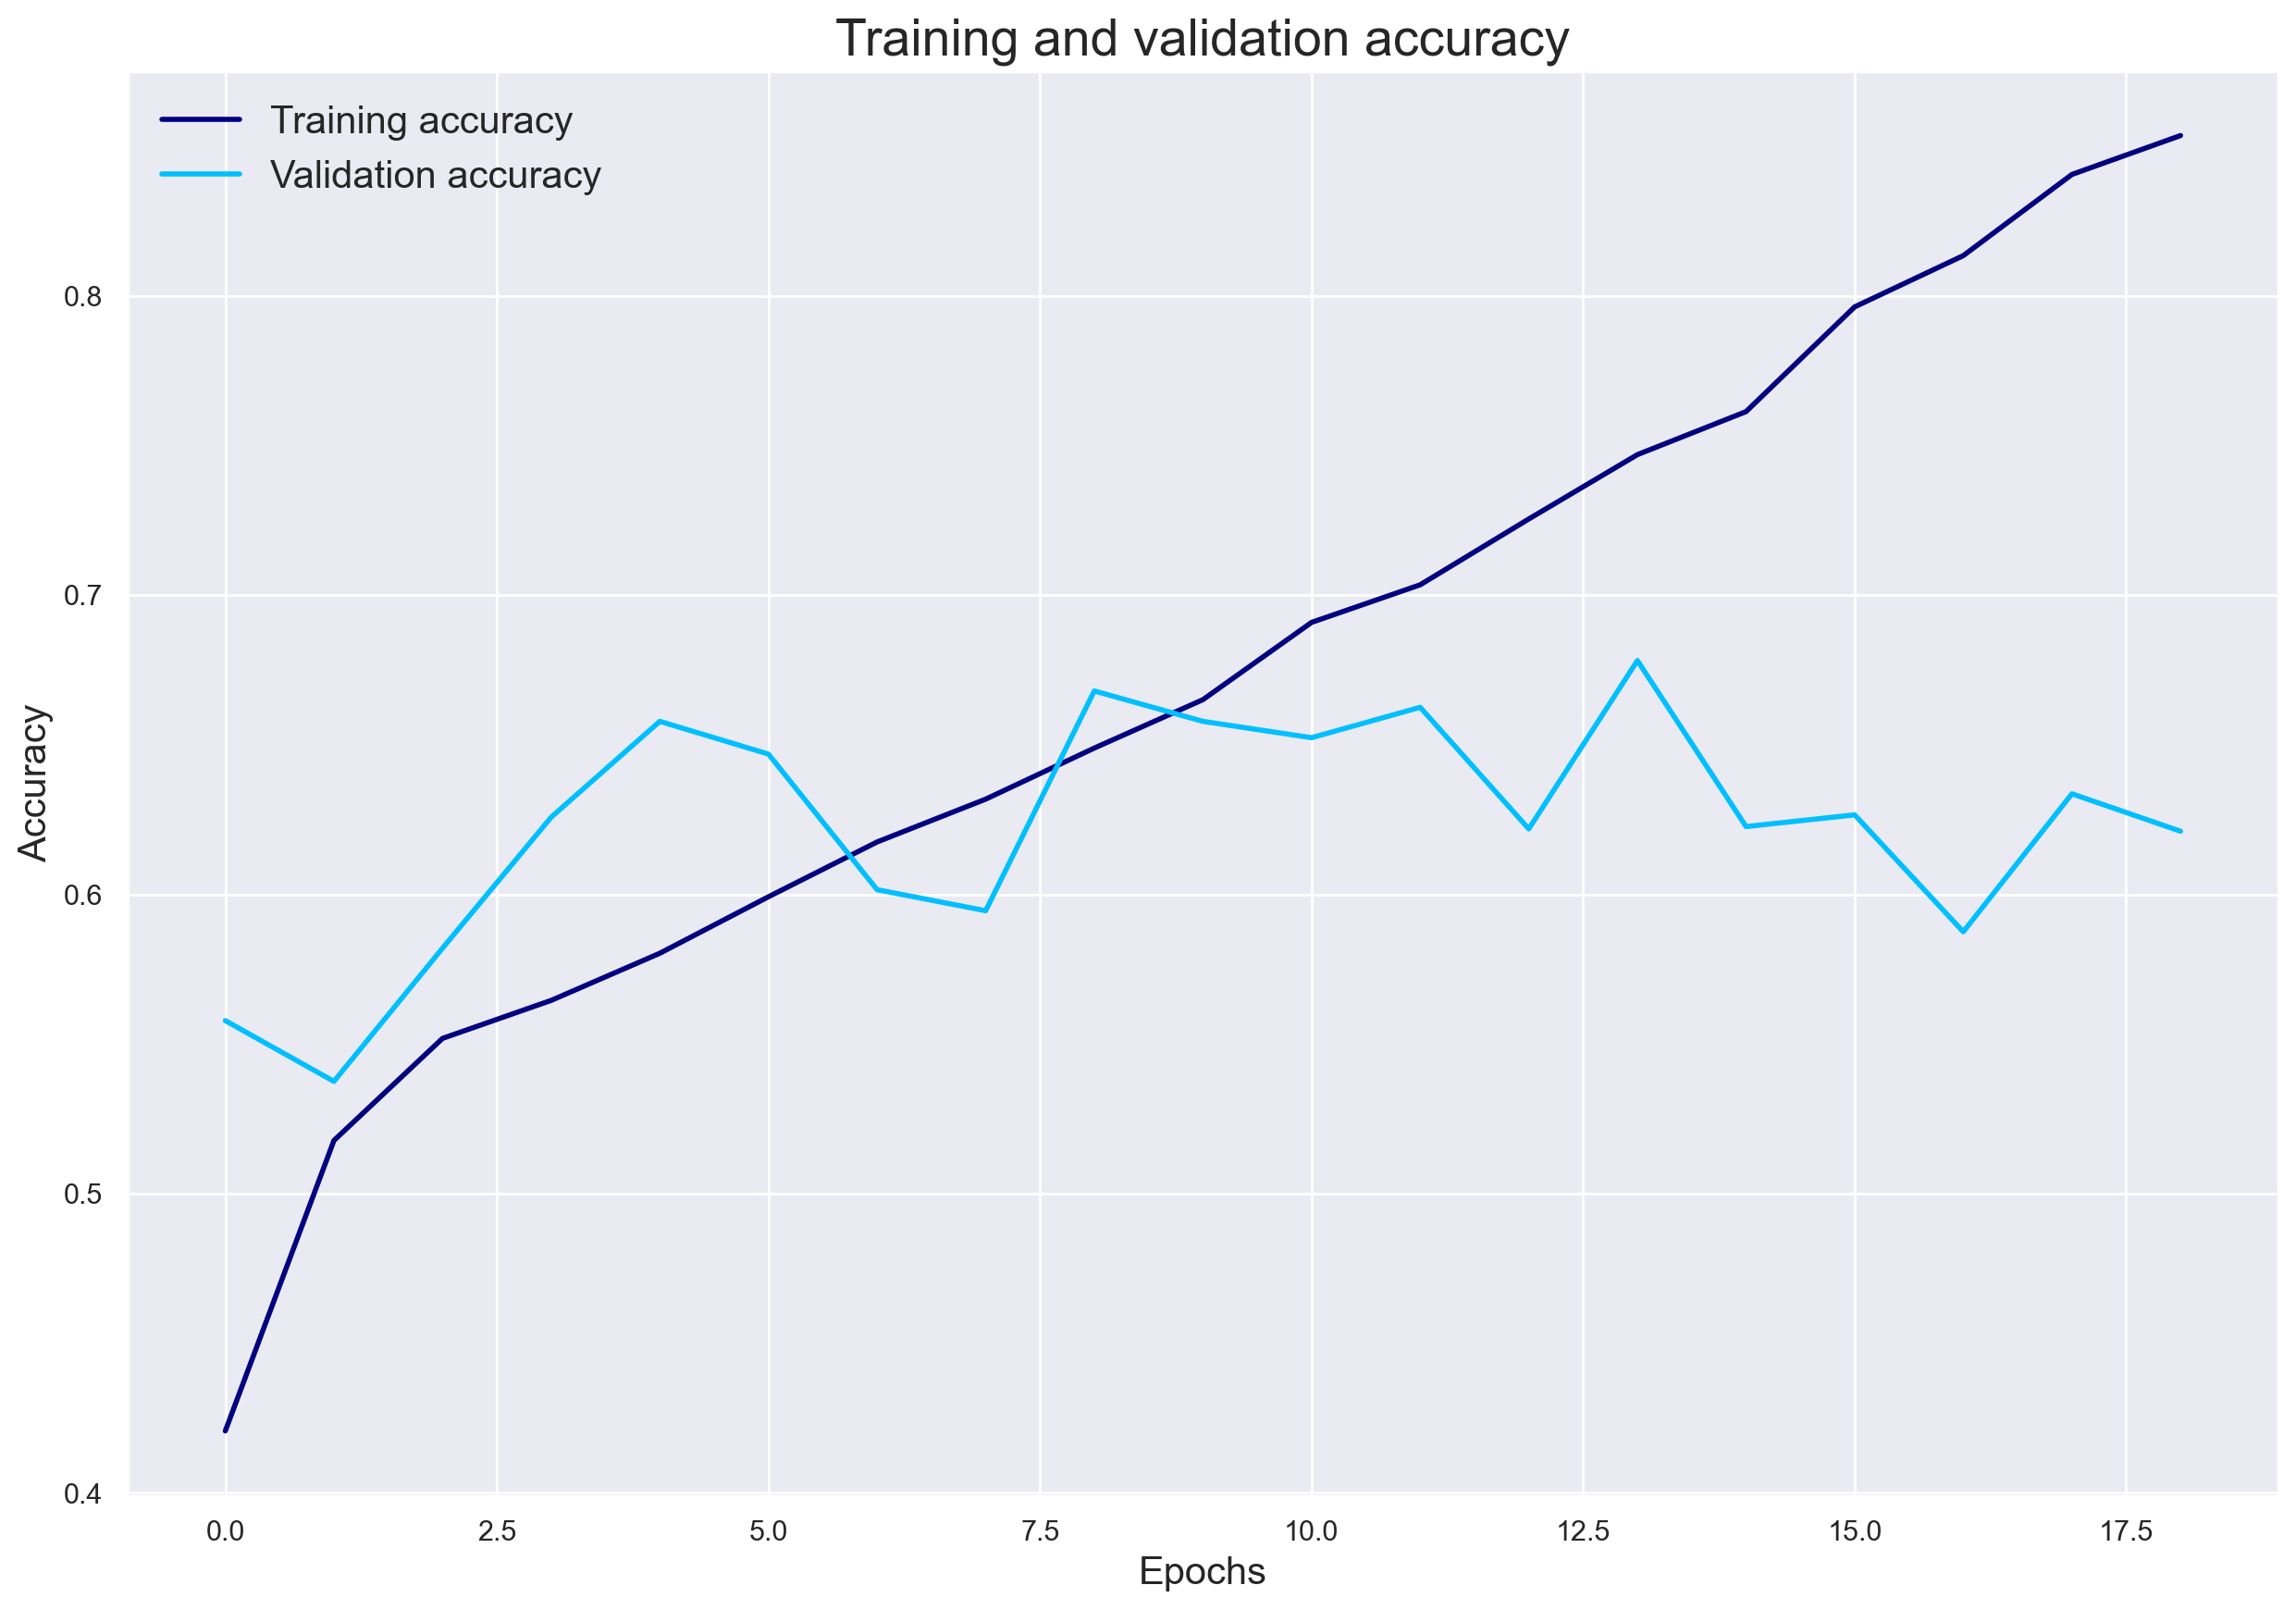

In [19]:
# Plot accuracy curves
plot_metric_curves(epochs, acc, val_acc, "navy", "deepskyblue", "Accuracy")

In [21]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=input_shape[:2],
        batch_size=40,
        class_mode='categorical',
        shuffle=False
        )

Found 2000 images belonging to 4 classes.


In [23]:
saved_model.evaluate(test_generator)

50/50 [==============================] - 49s 979ms/step - loss: 0.9610 - acc: 0.6220


[0.9609625339508057, 0.621999979019165]

As we can see, the level of dropout implemented was not enough to prevent overfitting from the model and only helped us marginally increase performance in the validation dataset.